# Introduction

RAG, or **R**etrieval **A**ugmented **G**eneration, is an architectural approach that can improve the effectiveness of large language model (LLM) applications. LLMs are quite expensive to train, as they require massive datasets. Currently, LLMs are trained on a wide variety of publicly available data. RAG addresses a key limitation of LLMs: the lack of access to specific information that may not be readily available in their training data or that needs to be kept up-to-date. This makes RAG ideal for applications like simple question-answering chatbots within your corporate wiki or a Confluence-like platform.

## RAG Architecture
In RAG, documents are vectorized and stored in a vector database (or index). When a user submits a query, the system retrieves a set of documents most similar to the query based on their vector representations. It then incorporates this information with the user's query into a prompt, which is fed to the LLM for answer generation.

## The Project Data
The rag-mini-wikipedia dataset from Hugging Face is a small-scale question-answering dataset specifically designed for testing and developing RAG models. Restricted to Wikipedia articles, it's suitable for tasks focused on factual information retrieval within that domain. The dataset consists of passages extracted from Wikipedia along with corresponding questions and their answers. The text is in English.

# Load the Dataset

In [ ]:
import pandas as pd

In [ ]:
text_corpus = pd.read_parquet("hf://datasets/rag-datasets/rag-mini-wikipedia/data/passages.parquet/part.0.parquet")
text_corpus.head()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


,passage
id,
0,"Uruguay (official full name in ; pron. , Eas..."
1,"It is bordered by Brazil to the north, by Arge..."
2,Montevideo was founded by the Spanish in the e...
3,The economy is largely based in agriculture (m...
4,"According to Transparency International, Urugu..."


In [ ]:
text_corpus.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3200 entries, 0 to 3200
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   passage  3200 non-null   string
dtypes: string(1)
memory usage: 50.0 KB


We have 3,200 records, all are strings.

# EDA
First let's see what are the length of the passages:
## Length

In [ ]:
text_corpus["length"] = text_corpus["passage"].str.len()
text_corpus["length"].head()

id
0    250
1    349
2    312
3    354
4    217
Name: length, dtype: Int64

In [ ]:
print(f"Number of records with empty text: {text_corpus['length'].isnull().sum()}")

Number of records with empty text: 0


We can see that the data type for the new "length" column is "Int64." This might cause a warning when using the pandas query method in the current version. To address this I converted it to a numpy-competible type:

In [ ]:
text_corpus["length"] = text_corpus["length"].astype("int64")
text_corpus["length"].info()

<class 'pandas.core.series.Series'>
Index: 3200 entries, 0 to 3200
Series name: length
Non-Null Count  Dtype
--------------  -----
3200 non-null   int64
dtypes: int64(1)
memory usage: 50.0 KB


Now we can extract some statstics:

In [ ]:
text_corpus["length"].describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95])

count    3200.000000
mean      389.848125
std       348.368869
min         1.000000
5%         26.000000
25%       108.000000
50%       299.000000
75%       574.000000
95%      1061.150000
max      2515.000000
Name: length, dtype: float64

And do some plotting:

In [ ]:
import matplotlib.pyplot as plt

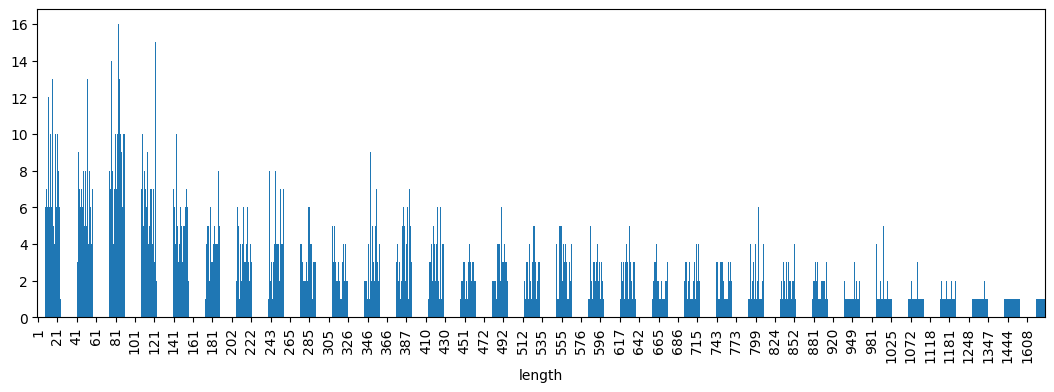

In [ ]:
text_corpus["length"].value_counts().reset_index().sort_values(["length"]).plot(x="length", y="count", legend=False, kind="bar")
plt.xticks(range(0, len(text_corpus["length"].unique()), 20), rotation=90)
fig = plt.gcf()
fig.set_size_inches(13, 4)
plt.show()

We can see that the lengths of the passages are grouped into ranges. However, there are gaps between these ranges where there are no value counts. This means there are missing lengths within the range distribution for some reason.

Let's what how passages with less then 26 characters are looks like (based on the 5th percentile):

In [ ]:
text_corpus.query("length < 26").head(10)

,passage,length
id,,
17,RÃ­o de la Plata in 1603.,25
28,Map of Uruguay,14
30,and with Brazil:,16
46,"INE, (in Spanish)",19
72,;Health rankings,16
73,;Other rankings,15
112,125px,5
136,150px,5
139,Anders Celsius,14


This passage doesn't convey an idea and can be disregarded. Now, let's move on to the number of words in a passage:

## Number of Words
We will consider empty spaces as word boundaries when counting the number of words in a passage. This means that any sequence of characters separated by whitespace will be counted as a separate word:

In [ ]:
text_corpus["words_num"] = text_corpus["passage"].str.split().str.len()
text_corpus["words_num"].head()

id
0    43
1    62
2    50
3    58
4    30
Name: words_num, dtype: int64

In [ ]:
print(f"Number of records with zero words in them: {text_corpus['words_num'].isnull().sum()}")

Number of records with zero words in them: 0


Now we can view some statstics on the new column:

In [ ]:
text_corpus["words_num"].describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95])

count    3200.000000
mean       62.103750
std        55.422049
min         1.000000
5%          4.000000
25%        17.000000
50%        48.000000
75%        92.000000
95%       169.000000
max       425.000000
Name: words_num, dtype: float64

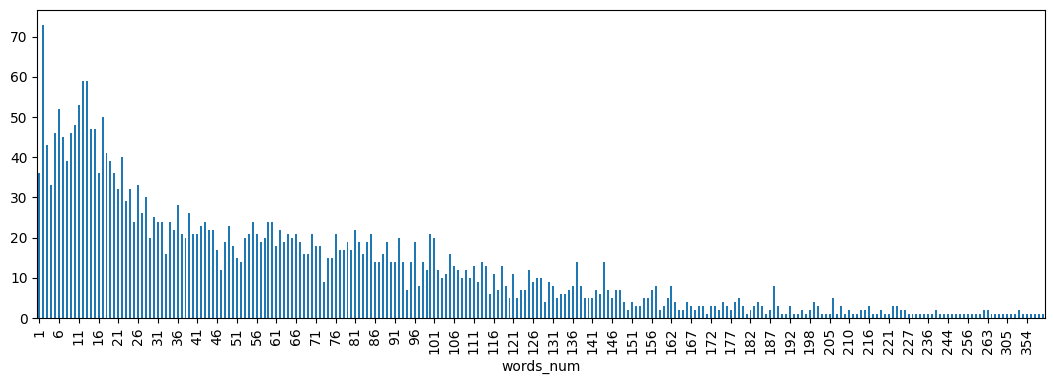

In [ ]:
text_corpus["words_num"].value_counts().reset_index().sort_values(["words_num"]).plot(x="words_num", y="count", legend=False, kind="bar")
plt.xticks(range(0, len(text_corpus["words_num"].unique()), 5), rotation=90)
fig = plt.gcf()
fig.set_size_inches(13, 4)
plt.show()

We can see that the distribution has a very long tail (which is expected). Interestingly, we also see that two-word passages have a particularly high count.

Let's see what passages with less than 4 words look like (based on the 5th percentile):

In [ ]:
text_corpus.query("words_num < 4").head(10)

,passage,length,words_num
id,,,
28,Map of Uruguay,14,3
30,and with Brazil:,16,3
36,"Montevideo, Uruguay's capital.",30,3
46,"INE, (in Spanish)",19,3
72,;Health rankings,16,2
73,;Other rankings,15,2
112,125px,5,1
126,Michael Faraday's signature,27,3
136,150px,5,1


Entries with less than 4 words or 26 characters might be too short to provide enough context for the RAG, and we can remove them from the dataset:

In [ ]:
text_corpus_cleaned = text_corpus.query("(words_num >= 4) & (length >= 26)").copy(deep=True)
text_corpus_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3032 entries, 0 to 3200
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   passage    3032 non-null   string
 1   length     3032 non-null   int64 
 2   words_num  3032 non-null   int64 
dtypes: int64(2), string(1)
memory usage: 94.8 KB


We are left with 3032 records (about 5.25% were removed). Now we can see what are most frequest words in the set:

## Most Frequent Words
First let's import NLTK and download the lastest stopwords:

In [ ]:
import nltk

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from nltk.corpus import stopwords

In [ ]:
stop_words = set(stopwords.words('english'))
list(stop_words)[:10]

['she', 'ain', 'not', 'whom', 'between', 'aren', 'mightn', 'than', 'y', 'does']

Now, we can create a clean passage with lowercased words, remove the stopwords and punctuation:

In [ ]:
text_corpus_cleaned['clean_passage'] = (
     text_corpus_cleaned['passage']
    .str.lower()
    .apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
    .str.replace(r'[^\w\s]', '', regex=True)
)

text_corpus_cleaned['clean_passage'].head()

id
0    uruguay official full name  pron  eastern repu...
1    bordered brazil north argentina across bank ur...
2    montevideo founded spanish early 18th century ...
3    economy largely based agriculture making 10 gd...
4    according transparency international uruguay s...
Name: clean_passage, dtype: object

Let's seperate the words by white space and aggreagate them into one list:

In [ ]:
all_text = text_corpus_cleaned['clean_passage'].str.split().explode().tolist()
all_text[:10]

['uruguay',
 'official',
 'full',
 'name',
 'pron',
 'eastern',
 'republic',
 'uruguay',
 'country',
 'located']

Using the Counter object we cas see what are the most common words:

In [ ]:
from collections import Counter

In [ ]:
word_counts = Counter(all_text)
most_common_word = word_counts.most_common(10)
print("Most common words:", most_common_word)

Most common words: [('also', 457), ('president', 426), ('one', 423), ('new', 414), ('first', 392), ('war', 329), ('roosevelt', 307), ('world', 278), ('two', 277), ('states', 276)]


The word "also", maybe isn't a stopword but in our case (for the EDA process), I think we can add also as a stop word:

In [ ]:
stop_words = set(stopwords.words('english') + ["also"])
text_corpus_cleaned['clean_passage'] = (
     text_corpus_cleaned['passage']
    .str.lower()
    .apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
    .str.replace(r'[^\w\s]', '', regex=True)
)

all_text = text_corpus_cleaned['clean_passage'].str.split().explode().tolist()
word_counts = Counter(all_text)
most_common_word = word_counts.most_common(10)
print("Most common words:", most_common_word)

Most common words: [('president', 426), ('one', 423), ('new', 414), ('first', 392), ('war', 329), ('roosevelt', 307), ('world', 278), ('two', 277), ('states', 276), ('national', 266)]


It seems that alot of passage are around presidents and wars. Let's generate a word cloud:

In [ ]:
from wordcloud import WordCloud

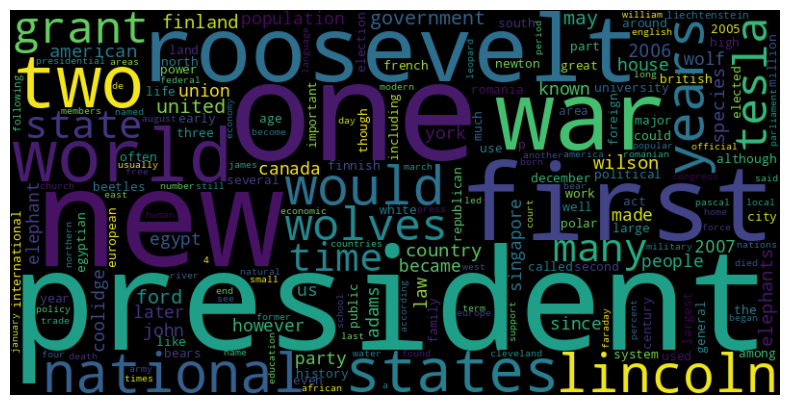

In [ ]:
wordcloud = WordCloud(width=800, height=400, background_color='black').generate_from_frequencies(word_counts)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

The dataset appears to be heavily focused on American history during World War II.

# Embeddings
The first step in the RAG process involves vectorizing all the documents in the dataset. To achieve this, I opted to use the sentence transformers package from Hugging Face:

In [ ]:
!pip install sentence_transformers

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [ ]:
from sentence_transformers import SentenceTransformer

And I'm going to use "all-MiniLM-L6-v2" model.

The all-MiniLM-L6-v2 model is a sentence transformer available on Hugging Face. This model is designed for sentence embedding, which means it converts sentences and short paragraphs into numerical representations (vectors) in a 384-dimensional space. These vectors capture the semantic meaning of the sentences. The model was trained on a large and diverse dataset of over 1 billion training pairs.

Architecture:
* The model is based on the MiniLM architecture, which stands for "Miniature Language Model".
* Specifically, it is a 6-layer transformer model, with each layer having an attention mechanism to capture dependencies between words in a sentence.
* The "L6" in its name indicates that it has 6 transformer layers.
* MiniLM is a distilled version of BERT (Bidirectional Encoder Representations from Transformers) and other similar transformer models.
* It uses a transformer architecture, which relies on self-attention mechanisms to capture contextual relationships between words in a sentence.

Compared to other high-quality sentence transformers, all-MiniLM-L6-v2 is known to be about 5 times faster. But, compared to the top-performing models, all-MiniLM-L6-v2 might deliver slightly lower embedding quality.

In [ ]:
encoder = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In the context of the sentence_transformers library by Hugging Face, the max sequence length refers to the maximum number of tokens that the model can process in a single input sequence. Tokens can be words, subwords, or characters, depending on the tokenizer used.

The all-MiniLM-L6-v2 model uses subword tokenization. This is common for models based on BERT and similar architectures, which utilize the WordPiece tokenization method.

The max sequence length of the all-MiniLM-L6-v2 model is 256 tokens. In this point in the reaserch I don't know what LLM model I'm going to use later. So, I'm going to use the same configuration as most of examples in the web, and limit the chunk to 256 character with 25 character as overlap.
## First Sentence as an Example
We are going to use the first sentence as an example to how to encode a simple sentence:

In [ ]:
sentence = text_corpus_cleaned["passage"].iloc[0]
sentence

'Uruguay (official full name in  ; pron.  , Eastern Republic of  Uruguay) is a country located in the southeastern part of South America.  It is home to 3.3 million people, of which 1.7 million live in the capital Montevideo and its metropolitan area.'

In [ ]:
encoder.encode(sentence)[:10]

array([ 0.00698538, -0.06149814, -0.06683704, -0.00828598,  0.04050031,
       -0.02582297,  0.08005101,  0.07768562, -0.00207005,  0.10649287],
      dtype=float32)

## Second Sentence as an Example
Let's try now on a longer sentence. The second sentence is 349 characters:

In [ ]:
sentence = text_corpus_cleaned["passage"].iloc[1]
sentence

'It is bordered by Brazil to the north, by Argentina across the bank of both the Uruguay River to the west and the estuary of RÃ\xado de la Plata to the southwest, and the South Atlantic Ocean to the southeast. It is the second smallest independent country in South America, larger only than Suriname and the French overseas department of French Guiana.'

In order to embbed it, will have to split it into chunks, and we are going to use overlapping. Overlap helps to avoid missing crucial information that falls right on a chunk boundary. This is like ensuring a search term isn't accidentally split in two, making it harder to find.

In [ ]:
def split_into_chunks(text, max_length, overlap):
    chunks = []
    start = 0
    while start < len(text):
        end = start + max_length
        chunks.append(text[start:end])
        start += (max_length - overlap)
        if end >= len(text):
            break
    return chunks

In [ ]:
max_length = 256
overlap = 25
chunks = split_into_chunks(sentence, max_length, overlap)

chunks

['It is bordered by Brazil to the north, by Argentina across the bank of both the Uruguay River to the west and the estuary of RÃ\xado de la Plata to the southwest, and the South Atlantic Ocean to the southeast. It is the second smallest independent country in ',
 't independent country in South America, larger only than Suriname and the French overseas department of French Guiana.']

We can we have two problems with the method:
1. The first chunk end on a white space and not a word boundry.
2. The second chunk start in the middle of a word.

Let's adjust the method to ensure chunks ends at a word boundary:

In [ ]:
def split_into_chunks(text, max_length, overlap):
    chunks = []
    start = 0
    while start < len(text):
        # Find the end of the chunk, ensuring it ends at a word boundary
        end = start + max_length
        if end < len(text):
            while end > start and not text[end].isspace():
                end -= 1
            if end == start:
                end = start + max_length  # Fallback to original max_length if no spaces found
        chunks.append(text[start:end])
        start = end - overlap
    return chunks

In [ ]:
chunks = split_into_chunks(sentence, max_length, overlap)
chunks

['It is bordered by Brazil to the north, by Argentina across the bank of both the Uruguay River to the west and the estuary of RÃ\xado de la Plata to the southwest, and the South Atlantic Ocean to the southeast. It is the second smallest independent country in',
 'st independent country in South America, larger only than Suriname and the French overseas department of French Guiana.']

Now we can fix the second problem, and ensure that a chunk won't start in a middle of a word:

In [ ]:
def split_into_chunks(text, max_length, overlap):
    chunks = []
    start = 0
    while start < len(text):
        # Find the end of the chunk, ensuring it ends at a word boundary
        end = start + max_length
        if end < len(text):
            while end > start and not text[end].isspace():
                end -= 1
            if end == start:
                end = start + max_length  # Fallback to original max_length if no spaces found
        chunk = text[start:end]

        # Adjust start to ensure chunk does not start in the middle of a word
        while start > 0 and not chunk[0].isspace() and not text[start - 1].isspace():
            start -= 1
            chunk = text[start:end]

        chunks.append(chunk)
        start = end - overlap
    return chunks

In [ ]:
chunks = split_into_chunks(sentence, max_length, overlap)
chunks

['It is bordered by Brazil to the north, by Argentina across the bank of both the Uruguay River to the west and the estuary of RÃ\xado de la Plata to the southwest, and the South Atlantic Ocean to the southeast. It is the second smallest independent country in',
 'smallest independent country in South America, larger only than Suriname and the French overseas department of French Guiana.']

Our sentences are looking good! However, the second sentence seems a bit short. To ensure we capture all important data, we can adjust our method. If a chunk falls below the maximum length, we can increase the overlap with the previous chunk to reach that limit:

In [ ]:
def split_into_chunks(text, max_length, overlap):
    chunks = []
    start = 0
    should_break=False
    if len(text) <= max_length:
        return [text.strip()]

    while start < len(text):
        # Find the end of the chunk, ensuring it ends at a word boundary
        end = start + max_length
        if end < len(text):
            while end > start and not text[end].isspace():
                end -= 1
            if end == start:
                end = start + max_length  # Fallback to original max_length if no spaces found
        if end >= len(text):
            should_break = True
            end = len(text) - 1
            start = end - max_length
        chunk = text[start:end]

        # Adjust start to ensure chunk does not start in the middle of a word
        while start > 0 and not chunk[0].isspace() and not text[start - 1].isspace():
            start -= 1
            chunk = text[start:end]

        start = end - overlap
        chunks.append(chunk)

        if should_break:
            break

    return chunks

In [ ]:
chunks = split_into_chunks(sentence, max_length, overlap)
chunks

['It is bordered by Brazil to the north, by Argentina across the bank of both the Uruguay River to the west and the estuary of RÃ\xado de la Plata to the southwest, and the South Atlantic Ocean to the southeast. It is the second smallest independent country in',
 'River to the west and the estuary of RÃ\xado de la Plata to the southwest, and the South Atlantic Ocean to the southeast. It is the second smallest independent country in South America, larger only than Suriname and the French overseas department of French Guiana']

In [ ]:
embeddings = encoder.encode(chunks)
len(embeddings)

2

In [ ]:
embeddings[0][:10]

array([ 0.09089241, -0.04216352, -0.058897  ,  0.00332258,  0.0518454 ,
        0.00152872, -0.02083002,  0.04281051, -0.00584225, -0.01636054],
      dtype=float32)

Great! Now we can extract chunks from all of the passages:

In [ ]:
all_chunks = text_corpus_cleaned["passage"].apply(lambda x: split_into_chunks(x, 256, 25)).explode().tolist()
all_chunks[:10]

['Uruguay (official full name in  ; pron.  , Eastern Republic of  Uruguay) is a country located in the southeastern part of South America.  It is home to 3.3 million people, of which 1.7 million live in the capital Montevideo and its metropolitan area.',
 'It is bordered by Brazil to the north, by Argentina across the bank of both the Uruguay River to the west and the estuary of RÃ\xado de la Plata to the southwest, and the South Atlantic Ocean to the southeast. It is the second smallest independent country in',
 'River to the west and the estuary of RÃ\xado de la Plata to the southwest, and the South Atlantic Ocean to the southeast. It is the second smallest independent country in South America, larger only than Suriname and the French overseas department of French Guiana',
 'Montevideo was founded by the Spanish in the early 18th century as a military stronghold. Uruguay won its independence in 1828 following a three-way struggle between Spain, Argentina and Brazil. It is a constitut

In [ ]:
vectors = encoder.encode(all_chunks)
vectors[0][:10]

array([ 0.00698543, -0.06149811, -0.06683702, -0.00828595,  0.04050032,
       -0.02582296,  0.08005103,  0.07768559, -0.00207011,  0.10649288],
      dtype=float32)

# Vector Database
A vector database is a specialized database optimized for storing, indexing, and searching high-dimensional vector embeddings. Each vector represents a data item within a continuous space where similar items are positioned closely together. The database excels at similarity searches using distance metrics like Euclidean distance or cosine similarity, often finding the nearest neighbors (k-NN) to a given query vector.

Unlike traditional relational (SQL) or NoSQL databases designed for structured or semi-structured data, respectively, vector databases prioritize efficient similarity search. While SQL databases focus on complex queries, joins, aggregations, and transactions, and NoSQL databases offer flexible data models and horizontal scaling, vector databases excel at rapid retrieval of items similar to a given query.

To achieve high performance, vector databases employ specialized indexing techniques such as HNSW, PQ, or IVF. This contrasts with SQL databases that optimize performance through indexing, normalization, and query optimization, and NoSQL databases that rely on sharding, replication, and tailored indexing for specific data models.

Here is a table summarizing popular vector databases compatible with Python, their pros and cons, and installation requirements:

| Vector Database | Pros                                                     | Cons                                                       | Installation Requirements               | Metadata Storage |
|-----------------|----------------------------------------------------------|------------------------------------------------------------|-----------------------------------------|-----------------|
| Pinecone        | - Fully managed service                                  | - Paid service with limited free tier                      | No special installation, cloud-based    | Yes             |
|                 | - Scalable and high performance                          | - Data privacy concerns with cloud storage                 |                                         |                 |
|                 | - Easy to integrate with Python                          |                                                            |                                         |                 |
|-----------------|----------------------------------------------------------|------------------------------------------------------------|-----------------------------------------|-----------------|
| FAISS           | - Open-source and free                                   | - Requires manual setup and configuration                  | Install via pip or compile from source  | No              |
|                 | - Highly efficient for large datasets                    | - Limited distributed capabilities                         |                                         |                 |
|                 | - Supports multiple distance metrics and indexing methods| - Lacks a web-based management interface                   |                                         |                 |
|-----------------|----------------------------------------------------------|------------------------------------------------------------|-----------------------------------------|-----------------|
| Milvus          | - Open-source with high performance                      | - Requires Docker for easy setup                           | Docker or Kubernetes recommended        | Yes             |
|                 | - Supports horizontal scaling and distributed deployment | - More complex setup compared to managed services          | Python SDK available via pip            |                 |
|                 | - Active community and extensive documentation           |                                                            |                                         |                 |
|-----------------|----------------------------------------------------------|------------------------------------------------------------|-----------------------------------------|-----------------|
| Weaviate        | - Open-source and easy to use                            | - Performance may vary based on setup                      | Docker recommended for setup            | Yes             |
|                 | - Built-in support for various ML models                 | - Less mature compared to other solutions                  | Python SDK available via pip            |                 |
|                 | - Supports hybrid search (vector + keyword)              |                                                            |                                         |                 |
|-----------------|----------------------------------------------------------|------------------------------------------------------------|-----------------------------------------|-----------------|
| Annoy           | - Extremely fast for read-heavy workloads                | - Limited to read-only once built                          | Install via pip                         | No              |
|                 | - Open-source and lightweight                            | - Not suitable for frequent updates                        |                                         |                 |
|                 | - Easy to use and integrates well with Python            | - Single-machine, not distributed                          |                                         |                 |
|-----------------|----------------------------------------------------------|------------------------------------------------------------|-----------------------------------------|-----------------|
| HNSWlib         | - High performance and accuracy                          | - Requires manual setup and configuration                  | Install via pip                         | No              |
|                 | - Open-source and easy to integrate                      | - Limited built-in scalability options                     |                                         |                 |
|                 | - Supports incremental updates to the index              |                                                            |                                         |                 |
|-----------------|----------------------------------------------------------|------------------------------------------------------------|-----------------------------------------|-----------------|
| MongoDB         | - Flexible schema for storing both vectors and metadata  | - Performance may vary based on the use case               | Install via MongoDB Atlas or on-premise | Yes             |
|                 | - Rich querying capabilities                             | - Requires additional setup for optimal vector search      | MongoDB Atlas or local installation     |                 |
|                 | - Mature ecosystem with extensive documentation          | - Not specialized for high-dimensional vector search       |                                         |                 |
|                 | - Good for applications needing both traditional and vector data |                                                    |                                         |                 |

I decided to focus on FAISS by Meta.

## FAISS
FAISS is a library for efficient similarity search and clustering of dense vectors. This is a specialized data structure built on top of the data (often the encoded vectors, not the raw data). It helps FAISS perform efficient similarity searches. Imagine an index in a book – it points you to specific locations in the book (data) quickly. Similarly, a FAISS index helps find similar data points (vectors) efficiently. All in-memnory.

It is an Index and not a database. Databases are designed for general data storage and retrieval, and updates are a core functionality. In short, databases are manly use for storing and managing the original data points.

While, FAISS indexes prioritize search speed. Updating individual entries within the complex structure of the index can be expensive. FAISS index built on encoded data from the database for fast similarity searches, with limitations in updating and removing records within the index itself.

In [ ]:
!pip install faiss-gpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 7.6 MB/s eta 0:00:00


In [ ]:
import faiss

In [ ]:
vector_dimensions = 384
index = faiss.IndexFlatIP(vector_dimensions)

In FAISS, I want to use Cosine Similarity to find the nearest vector in the index to the user query. As you can see above I chose product index, what I left is to normalize the vectors.

Cosine similarity measures the cosine of the angle between two vectors. It ranges from -1 (opposite directions) to 1 (same direction). When vectors are normalized (i.e., their L2 norm is 1), the inner product of two vectors approximates the cosine similarity. So, what is left before indexing a vector is to normalize it.

In [ ]:
faiss.normalize_L2(vectors)
vectors[0][:10]

array([ 0.00698543, -0.06149811, -0.06683702, -0.00828595,  0.04050032,
       -0.02582296,  0.08005103,  0.07768559, -0.00207011,  0.10649288],
      dtype=float32)

What is left is to add the vectors into the index:

In [ ]:
index.add(vectors)

# Retrieving Documents
We have an index and the original chunks. Let's try and search for documents in our index.

First let's read the test data set, and use some of its samples to see what chunks are being pulled:

In [ ]:
test_questions = pd.read_parquet("hf://datasets/rag-datasets/rag-mini-wikipedia/data/test.parquet/part.0.parquet")
test_questions.head()

,question,answer
id,,
0,Was Abraham Lincoln the sixteenth President of...,yes
2,Did Lincoln sign the National Banking Act of 1...,yes
4,Did his mother die of pneumonia?,no
6,How many long was Lincoln's formal education?,18 months
8,When did Lincoln begin his political career?,1832


In [ ]:
test_questions.info()

<class 'pandas.core.frame.DataFrame'>
Index: 918 entries, 0 to 1714
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   question  918 non-null    string
 1   answer    918 non-null    string
dtypes: string(2)
memory usage: 21.5 KB


Let's pick the first question and see what chunks are being pulled:

In [ ]:
question = test_questions["question"].iloc[0]
question

'Was Abraham Lincoln the sixteenth President of the United States?'

In [ ]:
question_vector = encoder.encode(question)
question_vector[:10]

array([-0.0037568 ,  0.03796383, -0.03182046, -0.04997676, -0.05045109,
       -0.00237988,  0.01975952, -0.01848559, -0.05412225,  0.03563   ],
      dtype=float32)

normalize_L2 method is expecting to get a marix and not a vector, so we need to reshape the quesion vector before normalizing it:

In [ ]:
question_vector = question_vector.reshape(1, -1)
faiss.normalize_L2(question_vector)
question_vector[0][:10]

array([-0.0037568 ,  0.03796383, -0.03182046, -0.04997676, -0.05045109,
       -0.00237988,  0.01975952, -0.01848559, -0.05412225,  0.03563   ],
      dtype=float32)

FAISS provides two results: cosine similarity scores and vector indices. In our case, the vector indices also correspond to the original chunk indices in the dataset:

In [ ]:
scores, chunks_indices = index.search(question_vector, 5)
print(f"Indices of nearest neighbours: {chunks_indices}")
print(f"Similarity scores: {scores}")

Indices of nearest neighbours: [[505 624 519 625 240]]
Similarity scores: [[0.74615026 0.65898675 0.57043445 0.5587513  0.55863833]]


We, can see that we got a matrix that each row represent a question vector's results. Let's see what chunks we got:

In [ ]:
similar_chunks = [all_chunks[idx] for idx in chunks_indices[0]]
similar_chunks

['Abraham Lincoln (February 12, 1809 â\x80\x93 April 15, 1865) was the sixteenth President of the United States, serving from March 4, 1861 until his assassination. As an outspoken opponent of the expansion of slavery in the United States, "[I]n his short',
 'On November 6, 1860, Lincoln was elected as the 16th President of the United States, beating Democrat Stephen A. Douglas, John C. Breckinridge of the Southern Democrats, and John Bell of the new Constitutional Union Party. He was the first Republican',
 'Scholars now rank Lincoln among the top three U.S. Presidents, with the majority of those surveyed placing him first. He is noted for his lasting influence on U.S. politics, including a redefinition of republicanism.  As Diggins explains, "Lincoln',
 ' was the first Republican president, winning entirely on the strength of his support in the North: he was not even on the ballot in nine states in the South, and won only 2 of 996 counties in the other Southern states. Lincoln gained

At least the first 4 chunks are related, and the top 2 answer the question. Hooray!

To ensure the retrieved chunks are highly relevant to the query, we can refine the cosine similarity scores. We'll focus on excluding chunks with very low similarity. First Let's find what is the minimal similarity score between the test questions and the our chunks:

In [ ]:
all_questions_vectors = encoder.encode(test_questions["question"].values)
faiss.normalize_L2(all_questions_vectors)
scores, chunks_indices = index.search(all_questions_vectors, 5)
scores

array([[0.7461502 , 0.6589868 , 0.5704346 , 0.5587513 , 0.55863833],
       [0.62817234, 0.598958  , 0.5854277 , 0.5559559 , 0.5438303 ],
       [0.5531045 , 0.546609  , 0.50290716, 0.48705873, 0.48498338],
       ...,
       [0.8341542 , 0.68338436, 0.6745739 , 0.66873914, 0.66801345],
       [0.77333814, 0.52656037, 0.5175959 , 0.5113119 , 0.50607187],
       [0.5874215 , 0.5614333 , 0.5613534 , 0.5179812 , 0.5092914 ]],
      dtype=float32)

In [ ]:
import numpy as np

In [ ]:
np.min(scores)

0.20478152

Now we can implement a filtering method to make sure that our context is relevant:

In [ ]:
def filter_indices(scores, chunks_indices):
    filtered_scores_indices = [(score, idx) for score, idx in zip(scores[0], chunks_indices[0]) if score > 0.2]

    if filtered_scores_indices:
        return zip(*filtered_scores_indices)
    return [], []

Let's try the method:

In [ ]:
filtered_scores, filtered_indices = filter_indices([[0.7461505, 0.65898716, 0.1, -0.5587512, -0.5586386 ]], [[505, 624, 519, 625, 240]])
print(filtered_indices)

(505, 624)


Great!

Let's use a LLM model to generate answers to our questions.
# LLM or Response Generator Model
The **meta-llama/Llama-2-7b-chat-hf** model from Hugging Face is an excellent choice for our task. It's part of Meta's Llama 2 series and is specifically fine-tuned with 7 billion parameters for dialogue applications.

Trained on a vast, publicly sourced dataset, this model excels in various domains. While the exact dataset composition remains undisclosed, it's clear that the model's versatility stems from its exposure to a wide range of text formats.

With a maximum sequence length of 4,096 tokens, the model efficiently processes text inputs. The model uses the SentencePiece tokenizer, which is a type of subword tokenizer that works similarly to Byte Pair Encoding (BPE) but is more flexible in handling the different scripts and languages by operating directly on raw text without needing whitespace or any other pre-tokenization. The tokenizer first split into tokens based on whitespace and special characters. Then,  iteratively merges the most frequent pair of bytes (or characters) in the vocabulary to form subword units. This continues until the entire text is tokenized into a series of subword tokens.

In [ ]:
model_id = "meta-llama/Llama-2-7b-chat-hf"

Now, First let's fetch the token to download the model from HugginFace Hub from my drive:

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
from pathlib import Path

In [ ]:
token = Path("/content", "drive", "My Drive", "tokens", "hugginface_token.txt").read_text()

Now let's donwload the model, first the tokenizer:

In [ ]:
from transformers import AutoTokenizer

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_id, token=token)

tokenizer_config.json:   0%|          | 0.00/1.62k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

Now when we are going to create our prompt for the LLM model we'll assign roles. In the context of LLMs like those used for chat, roles are used to define the different participants in a conversation. The three primary roles are:
*   **System**: This role provides initial instructions or context to guide the conversation. It sets the behavior and tone of the assistant (the AI). The system message is not typically visible to the user but shapes how the assistant responds. Example prompt: ```You are a helpful, knowledgeable assistant. Always provide concise and accurate answers, and remain polite and professional. If you don't know the answer to a question, be honest about it. Avoid giving legal, medical, or financial advice.```
*    **User**: This role represents the person interacting with the assistant (the AI). The user asks questions, provides information, or makes requests. Example prompt: ```What is the weather like today in New York City?```
*    **Assistant**: This role represents the AI or chatbot responding to the user's inputs. The assistant provides answers, performs tasks, or engages in dialogue as per the instructions given in the system message. Example prompt ```The weather in New York City today is sunny with a high of 85°F (29°C) and a low of 70°F (21°C).```

Other roles can be used depending on the specific implementation or use case, but they are less common. Some examples might include:
*   **Moderator**: A role that could oversee the conversation to ensure it adheres to specific guidelines or policies.
*   **Observer**: A role that monitors the conversation without actively participating, potentially for training or evaluation purposes.
*   **External Agent**: A role for integrations with external systems or services, allowing the assistant to interact with other software or databases on behalf of the user.


In our test dataset we can see that the answers are very short. Let's create a system prompt that will much this behaviour:

In [ ]:
prompt = [
  {"role": "system",
   "content":
      """You are a helpful, respectful, and honest assistant. Always
      answer as helpfully as possible, while being safe and unbiased. For yes or
      no questions, answer with 'Yes' or 'No.' If not, provide the most
      accurate, short and concise answer. Use provided context information to
      answer questions accurately when available."""
   },
  {"role": "user", "content": ""}
]

Much like tokenization, different models expect very different input formats for chat. Using the tokenizer, apply_chat_template method specify how to convert conversations, represented as lists of messages, into a single tokenizable string in the format that the model expects.

We give the apply_chat_template method our dictionary with roles, tell it not to tokenize it so it only apply the template, and ask it to end the prompt with the token that indicate the start of an assistant message:

In [ ]:
tokenized_chat = tokenizer.apply_chat_template(
  prompt,
  tokenize=False,
  add_generation_prompt=True
)

print(tokenized_chat)

<s>[INST] <<SYS>>
You are a helpful, respectful, and honest assistant. Always
      answer as helpfully as possible, while being safe and unbiased. For yes or
      no questions, answer with 'Yes' or 'No.' If not, provide the most 
      accurate, short and concise answer. Use provided context information to 
      answer questions accurately when available.
<</SYS>> [/INST]


Great! we have a prompt.

Now we need to adjust our user prompt, it's essential to provide a clear structure that includes both the context and the user query. There's a need to ensure there is a distinct separation between the context (retrieved information) and the user query. This helps the model understand the background information and the specific question it needs to answer.

I chose the following prompt structure:
```
### Context:
{context_information}

### User Query:
{user_query}

### Instructions:
Please provide a concise and accurate response based on the context above.
```

And if a context isn't retrived the prompt will be just the user query.

For the moment, let's focus on the example query from the first line in the test set:
```Was Abraham Lincoln the sixteenth President of the United States?```

And the given context:
```
['Abraham Lincoln (February 12, 1809 â\x80\x93 April 15, 1865) was the sixteenth President of the United States, serving from March 4, 1861 until his assassination. As an outspoken opponent of the expansion of slavery in the United States, "[I]n his short',
 'On November 6, 1860, Lincoln was elected as the 16th President of the United States, beating Democrat Stephen A. Douglas, John C. Breckinridge of the Southern Democrats, and John Bell of the new Constitutional Union Party. He was the first Republican',
 'Scholars now rank Lincoln among the top three U.S. Presidents, with the majority of those surveyed placing him first. He is noted for his lasting influence on U.S. politics, including a redefinition of republicanism.  As Diggins explains, "Lincoln',
 ' was the first Republican president, winning entirely on the strength of his support in the North: he was not even on the ballot in nine states in the South, and won only 2 of 996 counties in the other Southern states. Lincoln gained 1,865,908 votes (39.9%',
 'Millard Fillmore (January 7, 1800   March 8, 1874) was the thirteenth President of the United States, serving from 1850 until 1853, and the last member of the Whig Party to hold that office. He was the second Vice President to assume the Presidency upon']
 ```

In [ ]:
def generate_numbered_context(context_sentences):
   formatted_context = ""
   for i, sentence in enumerate(context_sentences, start=1):
        formatted_context += f"{i}. {sentence}\n"
   return formatted_context

In [ ]:
prompt = [
  {"role": "system",
   "content":
      """You are a helpful, respectful, and honest assistant. Always
      answer as helpfully as possible, while being safe and unbiased. For yes or
      no questions, answer with 'Yes' or 'No.' If not, provide the most
      accurate, short and concise answer. Use provided context information to
      answer questions accurately when available."""
   },
  {"role": "user", "content":
   f"""
   ### Context:
   {generate_numbered_context(similar_chunks)}

   ### User Query:
   {question}

   ### Instructions:
   Please provide a concise and accurate response based on the context above.
   """
   }
]

tokenized_chat = tokenizer.apply_chat_template(
  prompt,
  tokenize=False,
  add_generation_prompt=True
)

print(tokenized_chat)

<s>[INST] <<SYS>>
You are a helpful, respectful, and honest assistant. Always
      answer as helpfully as possible, while being safe and unbiased. For yes or
      no questions, answer with 'Yes' or 'No.' If not, provide the most 
      accurate, short and concise answer. Use provided context information to 
      answer questions accurately when available.
<</SYS>>


   ### Context:
   1. Abraham Lincoln (February 12, 1809 â April 15, 1865) was the sixteenth President of the United States, serving from March 4, 1861 until his assassination. As an outspoken opponent of the expansion of slavery in the United States, "[I]n his short
2. On November 6, 1860, Lincoln was elected as the 16th President of the United States, beating Democrat Stephen A. Douglas, John C. Breckinridge of the Southern Democrats, and John Bell of the new Constitutional Union Party. He was the first Republican
3. Scholars now rank Lincoln among the top three U.S. Presidents, with the majority of those surveyed pl

Looks like a great prompt to me. Given that generating an answer might take a significant amount of time due to my settings, let's create a method that takes the user query and returns a tailored prompt:

In [ ]:
system_prompt = "You are a helpful, respectful, and honest assistant. Always\n" + \
                "answer as helpfully as possible, while being safe and unbiased. For\n" + \
                "yes or no questions, answer with 'Yes' or 'No.' If not, provide the\n" + \
                "most accurate, short and concise answer. Use provided context\n" + \
                "information to answer questions accurately when available."

In [ ]:
def generate_prompt(user_query: str) -> str:
  # First let's encode the user query
  user_query_vector = encoder.encode(user_query).reshape(1, -1)
  # Second vector L2 normalization
  faiss.normalize_L2(user_query_vector)
  # Now let's search the index
  scores, chunks_indices = index.search(user_query_vector, 5)
  # Reduce indices with less than zero similarity score
  _ , filtered_indices = filter_indices(scores, chunks_indices)
  if len(filtered_indices) > 0:
    # Get the context
    similar_chunks = [all_chunks[idx] for idx in filtered_indices]
    # Generate the prompt
    context = f"### Context:\n{generate_numbered_context(similar_chunks)}"
    user_query_text = f"### User Query:\n{user_query}"
    instructions = "### Instructions:\n" + \
                   "Please provide a concise and accurate response based on " + \
                   "the context above if it is relevant."
    prompt = [
          {"role": "system", "content": system_prompt},
          {"role": "user", "content":
           f"{context}\n{user_query_text}\n\n{instructions}"
           }
        ]
  else:
    # If no context is found
    prompt = [
          {"role": "system", "content": system_prompt},
          {"role": "user", "content": f"{user_query}"}
        ]
  return tokenizer.apply_chat_template(prompt, tokenize=False,
                                        add_generation_prompt=True)

In [ ]:
tokenized_chat = generate_prompt(question)
print(tokenized_chat)

<s>[INST] <<SYS>>
You are a helpful, respectful, and honest assistant. Always
answer as helpfully as possible, while being safe and unbiased. For
yes or no questions, answer with 'Yes' or 'No.' If not, provide the
most accurate, short and concise answer. Use provided context
information to answer questions accurately when available.
<</SYS>>

### Context:
1. Abraham Lincoln (February 12, 1809 â April 15, 1865) was the sixteenth President of the United States, serving from March 4, 1861 until his assassination. As an outspoken opponent of the expansion of slavery in the United States, "[I]n his short
2. On November 6, 1860, Lincoln was elected as the 16th President of the United States, beating Democrat Stephen A. Douglas, John C. Breckinridge of the Southern Democrats, and John Bell of the new Constitutional Union Party. He was the first Republican
3. Scholars now rank Lincoln among the top three U.S. Presidents, with the majority of those surveyed placing him first. He is noted for 

Last thing before seeing if the LLM can provide answer to the prompt, let's save and download our the data:

In [ ]:
faiss.write_index(index, "rag-mini-wikipedia_chunks_faiss_index.index")

In [ ]:
import pickle

In [ ]:
with Path("rag-mini-wikipedia_all_chunks.pkl").open("wb") as chunks_pickled:
  pickle.dump(all_chunks, chunks_pickled)

In [ ]:
from google.colab import files

In [ ]:
files.download("rag-mini-wikipedia_chunks_faiss_index.index")
files.download("rag-mini-wikipedia_all_chunks.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Now what is left is to generate an answer to the prompt:

In [ ]:
from transformers import pipeline

In [ ]:
pipe = pipeline("text-generation", model=model_id, device_map="auto",
                num_return_sequences=1, do_sample=True, token=token, top_k=5,
                max_new_tokens=50, return_full_text=False)

config.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

Let's try and generate text:

In [ ]:
sequences = pipe(tokenized_chat)

for seq in sequences:
    print(f"Result: {seq['generated_text']}")

Result:   Yes. Abraham Lincoln was the 16th President of the United States, serving from March 4, 1861 until his assassination on April 15, 1865.


# Conclusions
This project aims primarily to demonstrate the potential of using Retrieval Augmented Generation (RAG). The model and data employed in this project do not represent an ideal scenario, as the model is trained on extensive knowledge (including Wikipedia), and the data is general knowledge sourced from Wikipedia. The optimal use case for RAG involves more specific knowledge domains, such as biomedicine, or information that requires constant updates. In my opinion, RAG is ideally suited for creating a simple question-answering chatbot for your corporate Wikipedia or Confluence-like platform.

In this project, I demonstrated how to encode paragraphs of knowledge into vectors using the Sentence Transformer library from HuggingFace. These vectors were then stored in a FAISS vector index from Meta. Given a query, the top 5 most similar paragraphs were retrieved based on cosine similarity. Finally, I engineered a prompt to leverage a trained Large Language Model (LLM) and generate an answer based on the extracted knowledge or context.

Due to resource constraints within my environment, I had to adopt a simplified approach such as segmentation of the paragprapgs based on charcters count. Ideally, a more advanced sentence transformer model like MPNet would be preferable. MPNet (Masked and Permuted Network) is a state-of-the-art architecture that surpasses BERT and MiniLM by combining masked and permuted language modeling. This approach enables MPNet to learn richer representations, leading to improved performance on various NLP tasks, including sentence embedding. The `all-mpnet-base-v2 model` generates 768-dimensional embeddings, capturing more nuanced semantic information suitable for tasks requiring granular understanding.  Similar to MiniLM models trained on extensive corpora like Wikipedia and BookCorpus, MPNet benefits from comparable training data but incorporates masked and permuted language modeling for enhanced representation learning. While `all-MiniLM-L6-v2` offers speed and efficiency for resource-limited scenarios, `all-mpnet-base-v2` excels in accuracy and semantic depth, provided the computational resources are available.

I relied heavily on online examples for determining the optimal chunk size, which led to the decision to use 256 characters with a 25-character overlap. This approach was adopted despite the fact that both the sentence transformer and the LLM employ sub-word tokenizers. Alternative strategies for improving chunk selection include intelligently determining chunk size based on metrics like average response time or accuracy (facilitated by the LangChain Python package) and semantic chunking to create more contextually relevant text segments (also achievable with LangChain). Even a simple approach like segmenting based on newlines rather than character count could enhance the context provided to the LLM.

The context presented to the LLM can be further enhanced through intelligent reranking of the retrieved passages. By adjusting relevance thresholds and filtering out irrelevant content, it's possible to refine the results and provide the LLM with a more focused set of information.

Ultimately, a critical scientific component missing from this project is a thorough evaluation of the model and the extent to which RAG enhances question-answering capabilities. Each step of the process should be assessed, and different approaches compared. Specific metrics should be defined upfront and monitored throughout the project.

# Future Steps
1. **Enhance EDA with Topic Modeling**: Conduct in-depth Exploratory Data Analysis (EDA) on the `rag-mini-wikipedia` dataset utilizing topic modeling techniques to gain deeper insights.
2. **Comparative Analysis of Sentence Transformers**: Conduct a more thorough comparison between `sentence-transformers/all-mpnet-base-v2` and `sentence-transformers/all-MiniLM-L6-v2` to assess their performance differences.
3. **Integrate LangChain for Evaluation**: Incorporate the LangChain Python package to implement metrics and evaluate the performance of each project stage.
4. **Explore Production-Grade Databases**: Experiment with production-grade databases, such as Elasticsearch or MongoDB, for potential use cases with appropriate configurations, without limiting options to vector databases.
5. **Refine Prompt Engineering for Yes/No Answers**: Optimize prompt engineering techniques to exclusively generate Yes or No responses for corresponding queries.
6. **Focus on Specific Domains and LLMs**: Apply the RAG approach to specialized knowledge domains like biomedicine and information requiring constant updates. Consider using LLMs with limited general knowledge to highlight performance improvements.